# ⚡ FairFace 최적화 학습 코드 (RegNet + CatchCam 적합 버전)
- RegNet
- FocalLoss + LabelSmoothing
- AdamW + CosineAnnealing
- Dropout + GELU
- CLAHE + RandomAugment
- 회귀 제거 → 분류만 추론용 사용

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import random
from PIL import Image, ImageEnhance, ImageFilter

# ✅ 데이터 전처리 (CLAHE + RandomAugment)
class CLAHETransform:
    def __call__(self, img):
        import cv2
        import numpy as np
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img)
        l = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(l)
        img = cv2.merge((l,a,b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)

class RandomAugment:
    def __call__(self, img):
        ops = [
            lambda x: x.filter(ImageFilter.GaussianBlur(radius=1)),
            lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.8,1.2)),
            lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.8,1.2)),
            lambda x: ImageEnhance.Color(x).enhance(random.uniform(0.8,1.2)),
        ]
        op = random.choice(ops)
        return op(img)

transform_trainval = transforms.Compose([
    CLAHETransform(),
    RandomAugment(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# ✅ 데이터셋 및 DataLoader 준비
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

# 불러올 새로운 CSV (나이 6단계로 병합된 파일)
df = pd.read_csv("C:/TrainTest/balanced_dataset_6group.csv")

# 라벨 인코딩
gender_map = {'Male': 0, 'Female': 1}
age_group_map = {'0-9': 0, '10-19': 1, '20-29': 2, '30-39': 3, '40-59': 4, '60+': 5}
df['gender_label'] = df['gender'].map(gender_map)
df['age_label'] = df['age_group'].map(age_group_map)

# train/val split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['age_label'], random_state=42)
test_df = pd.read_csv("C:/TrainTest/fairface_label_val_combined_6age.csv")

# Dataset 클래스 정의
class FairFaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['full_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        gender = row['gender_label']
        age = row['age_label']
        return img, int(gender), int(age), 0  # age regression dummy

# DataLoader 설정
train_loader = DataLoader(FairFaceDataset(train_df, transform=transform_trainval), batch_size=32, shuffle=True)
val_loader = DataLoader(FairFaceDataset(val_df, transform=transform_trainval), batch_size=32, shuffle=False)
test_loader = DataLoader(FairFaceDataset(test_df, transform=transform), batch_size=32, shuffle=False)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 59475, Val: 14869, Test: 10954


In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
# 배치 하나 꺼내기
images, gender_labels, age_labels,_ = next(iter(train_loader))

print("image shape:", images.shape)
print("gender label shape:", gender_labels.shape)
print("age label  shape:", age_labels.shape)


# 첫 번째 이미지 시각화
img = torchvision.utils.make_grid(images[:])  # 앞에서 4개만 보기
img = img.permute(1, 2, 0)  # CHW -> HWC
img = img.numpy()
img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # 역정규화
img = np.clip(img, 0, 1)

plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.title("TrainLoader image (CLAHE)")
plt.axis('off')
plt.show()

In [ ]:
# ✅ 모델 정의 (회귀 제거 + Dropout + GELU)
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import regnet_y_800mf, RegNet_Y_800MF_Weights


class MultiTaskNet(nn.Module):
    def __init__(self, num_gender=2, num_age=9):
        super().__init__()
        base = regnet_y_800mf(weights=RegNet_Y_800MF_Weights.IMAGENET1K_V1)
        in_features = base.fc.in_features
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # 마지막 fc 제거

        self.gender_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_gender)
        )
        self.age_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_age)
        )
        self.age_reg_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.backbone(x).flatten(1)
        gender = self.gender_head(x)
        age_class = self.age_head(x)
        age_reg = self.age_reg_head(x).squeeze(1)
        return gender, age_class, age_reg


In [ ]:
# ✅ 손실함수 (FocalLoss + LabelSmoothing)
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        logprobs = F.log_softmax(pred, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        return (confidence * nll_loss + self.smoothing * smooth_loss).mean()

In [ ]:
# ✅ 학습 준비
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = MultiTaskNet().to('cuda' if torch.cuda.is_available() else 'cpu')
device = next(model.parameters()).device

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

loss_gender = FocalLoss()
loss_age = LabelSmoothingCE(smoothing=0.1)

best_acc = 0.0



In [ ]:
# ✅ 학습 루프 (회귀 포함 + Validation 정확도 및 손실 출력)
from tqdm import tqdm

loss_reg = nn.SmoothL1Loss()
age_centers = torch.tensor([1, 6, 14, 24, 34, 44, 54, 64, 75], device=device)
train_losses, val_accuracies = [], []
best_acc = 0.0
save_path = 'C:/TrainTest/models/best_model_test.pt'

eporch_time = 50
early_stop_patience = 3
epochs_no_improve = 0
best_val_loss = float('inf')

for epoch in range(eporch_time):
    model.train()
    running_loss, correct_gender, correct_age, total = 0, 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/10]", ncols=100)

    for images, gender_labels, age_labels, _ in loop:
        images = images.to(device)
        gender_labels = gender_labels.to(device)
        age_labels = age_labels.to(device)

        optimizer.zero_grad()
        gender_logits, age_logits, age_reg = model(images)
        reg_targets = age_centers[age_labels]
        loss = (
            loss_gender(gender_logits, gender_labels)
            + loss_age(age_logits, age_labels)
            + 0.3 * loss_reg(age_reg, reg_targets)
        )
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_gender += (gender_logits.argmax(1) == gender_labels).sum().item()
        correct_age += (age_logits.argmax(1) == age_labels).sum().item()
        total += gender_labels.size(0)

        loop.set_postfix({
            "Loss": f"{running_loss/(total//32):.4f}",
            "G_Acc": f"{correct_gender/total:.4f}",
            "A_Acc": f"{correct_age/total:.4f}"
        })

    # ✅ 검증 루프
    model.eval()
    gender_preds, gender_true = [], []
    age_preds, age_true = [], []
    val_loss = 0.0
    with torch.no_grad():
        for images, g_labels, a_labels, _ in val_loader:
            images = images.to(device)
            g_labels = g_labels.to(device)
            a_labels = a_labels.to(device)
            g_out, a_out, a_reg = model(images)
            reg_targets = age_centers[a_labels]
            v_loss = (
                loss_gender(g_out, g_labels)
                + loss_age(a_out, a_labels)
                + 0.3 * loss_reg(a_reg, reg_targets)
            )
            val_loss += v_loss.item()
            gender_preds += g_out.argmax(1).cpu().tolist()
            age_preds += a_out.argmax(1).cpu().tolist()
            gender_true += g_labels.cpu().tolist()
            age_true += a_labels.cpu().tolist()

    val_gender_acc = sum([p==t for p,t in zip(gender_preds, gender_true)]) / len(gender_true)
    val_age_acc = sum([p==t for p,t in zip(age_preds, age_true)]) / len(age_true)
    val_loss /= len(val_loader)
    print(f"[Validation] Loss: {val_loss:.4f}, Gender Acc: {val_gender_acc:.4f}, Age Acc: {val_age_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        best_val_loss = val_loss
        epochs_no_improve = 0
        print(f"✅ Best model saved at Epoch {epoch+1}")

    else:
        epochs_no_improve += 1
        print(f"🛑 No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stop_patience:
        print(f"\n⏹ Early stopping triggered at Epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
        break


Epoch [1/10]: 100%|████| 1859/1859 [09:06<00:00,  3.40it/s, Loss=3.1082, G_Acc=0.7932, A_Acc=0.5427]


[Validation] Loss: 2.7879, Gender Acc: 0.8631, Age Acc: 0.5866
✅ Best model saved at Epoch 1


Epoch [2/10]: 100%|████| 1859/1859 [06:00<00:00,  5.15it/s, Loss=2.6458, G_Acc=0.8543, A_Acc=0.6130]


[Validation] Loss: 2.6522, Gender Acc: 0.8816, Age Acc: 0.5936
✅ Best model saved at Epoch 2


Epoch [3/10]: 100%|████| 1859/1859 [06:02<00:00,  5.13it/s, Loss=2.4738, G_Acc=0.8717, A_Acc=0.6450]


[Validation] Loss: 2.3748, Gender Acc: 0.8876, Age Acc: 0.6279
✅ Best model saved at Epoch 3


Epoch [4/10]: 100%|████| 1859/1859 [06:11<00:00,  5.00it/s, Loss=2.3235, G_Acc=0.8790, A_Acc=0.6717]


[Validation] Loss: 2.4153, Gender Acc: 0.8899, Age Acc: 0.6231
🛑 No improvement for 1 epoch(s).


Epoch [5/10]: 100%|████| 1859/1859 [06:19<00:00,  4.90it/s, Loss=2.2020, G_Acc=0.8882, A_Acc=0.6971]


[Validation] Loss: 2.3499, Gender Acc: 0.8885, Age Acc: 0.6368
✅ Best model saved at Epoch 5


Epoch [6/10]: 100%|████| 1859/1859 [06:18<00:00,  4.91it/s, Loss=2.0829, G_Acc=0.8926, A_Acc=0.7188]


[Validation] Loss: 2.4410, Gender Acc: 0.8922, Age Acc: 0.6189
🛑 No improvement for 1 epoch(s).


Epoch [7/10]: 100%|████| 1859/1859 [06:15<00:00,  4.94it/s, Loss=1.9919, G_Acc=0.8958, A_Acc=0.7410]


[Validation] Loss: 2.3321, Gender Acc: 0.8931, Age Acc: 0.6389
✅ Best model saved at Epoch 7


Epoch [8/10]: 100%|████| 1859/1859 [06:17<00:00,  4.93it/s, Loss=1.8718, G_Acc=0.8988, A_Acc=0.7670]


[Validation] Loss: 2.3832, Gender Acc: 0.8927, Age Acc: 0.6381
🛑 No improvement for 1 epoch(s).


Epoch [9/10]: 100%|████| 1859/1859 [06:18<00:00,  4.92it/s, Loss=1.7778, G_Acc=0.9047, A_Acc=0.7883]


[Validation] Loss: 2.4293, Gender Acc: 0.8937, Age Acc: 0.6291
🛑 No improvement for 2 epoch(s).


Epoch [10/10]: 100%|███| 1859/1859 [06:16<00:00,  4.94it/s, Loss=1.7004, G_Acc=0.9083, A_Acc=0.8059]


[Validation] Loss: 2.4594, Gender Acc: 0.8861, Age Acc: 0.6201
🛑 No improvement for 3 epoch(s).

⏹ Early stopping triggered at Epoch 10. Best Val Loss: 2.3321


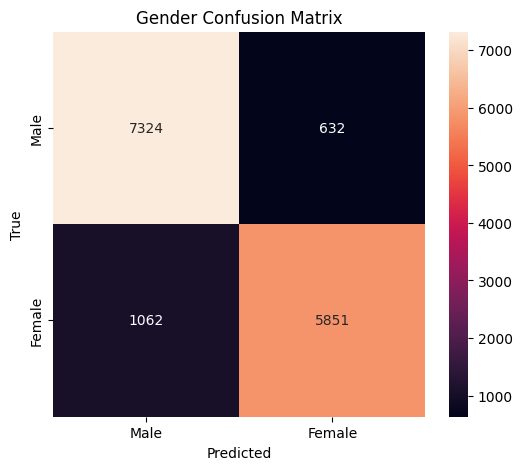

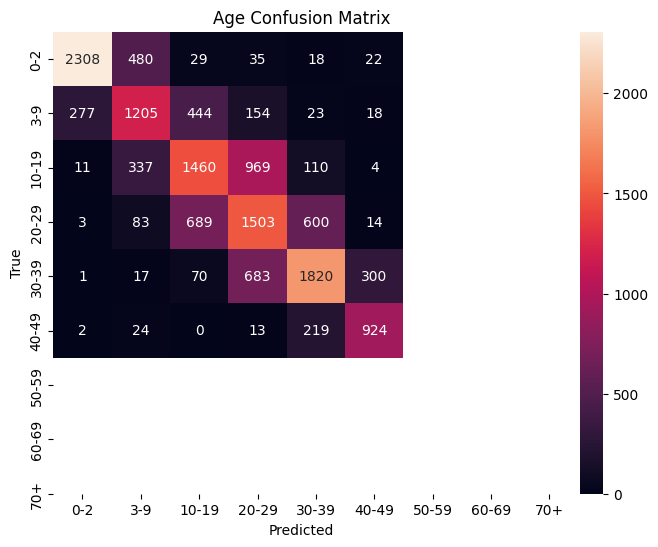

In [ ]:
# ✅ Confusion Matrix 시각화
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(gender_true, gender_preds), annot=True, fmt='d', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(8,6))
age_labels = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
sns.heatmap(confusion_matrix(age_true, age_preds), annot=True, fmt='d', xticklabels=age_labels, yticklabels=age_labels)
plt.title('Age Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# ✅ ONNX 포팅용 내보내기
model.load_state_dict(torch.load(save_path))
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, "catchcam_export.onnx",
                  input_names=['input'],
                  output_names=['gender', 'age'],
                  dynamic_axes={'input': {0: 'batch'}, 'gender': {0: 'batch'}, 'age': {0: 'batch'}},
                  opset_version=11)
print("✅ ONNX 파일 저장 완료: catchcam_export.onnx")

In [ ]:
# ✅ ONNX 포팅용 내보내기 (고정 입력 버전)
import torch

# ✅ 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ 학습된 모델 불러오기
model = MultiTaskNet()
model.load_state_dict(torch.load("C:/TrainTest/models/best_model_test.pt", map_location=device))
model.to(device)
model.eval()

# ✅ 고정 입력 크기 설정
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# ✅ ONNX 변환 시 gender + age 출력만 포함 (regression 제외)
with torch.no_grad():
    gender_logits, age_logits, _ = model(dummy_input)
    export_output = torch.cat([gender_logits, age_logits], dim=1)  # [B, 8]

# ✅ ONNX로 내보내기
torch.onnx.export(
    model,
    dummy_input,
    "gender_age_kl630_regnet.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
    do_constant_folding=True
)

print("✅ ONNX 변환 완료: gender_age_kl630_regnet.onnx")